# Lab 2, Problem 1 - Machine Learning for Industry
Linköping University, Fall 2019.

Author: Mattias Villani, Linköping and Stockholm University, http://mattiasvillani.com

The aim of this part of Lab 2 is to build a classification model for predicting if an items get sold at an eBay auction before the auction ends. The dataset contains data from 1000 auctions of collector coins. The dataset was collected and first analyzed in 

Wegmann and Villani. 'Bayesian Inference in Structural Second-Price Common Value Auctions', *Journal of Business & Economic Statistics*, 2011.

#### A first look at the dataset

Let's get started by loading some libraries and loading the data from the repository.

In [111]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(seed=123) # Set the seed for reproducibility

In [112]:
eBayData = pd.read_csv('https://github.com/STIMALiU/ml4industry/raw/master/Labs/eBayData.csv', sep = ',')
eBayData.head()

,nBids,PowerSeller,VerifyID,Sealed,Minblem,MajBlem,LargNeg,LogBook,MinBidShare,Sold
0,2,0,0,0,0,0,0,-0.2237,-0.2088,True
1,6,1,0,0,0,0,0,0.6073,-0.3478,True
2,1,1,0,0,0,0,0,0.0332,0.4423,True
3,1,0,0,0,1,0,0,0.3755,0.1441,True
4,4,0,0,0,0,0,1,1.4347,-0.4104,True


The response is the last column <tt>Sold</tt> and we will use all the other features except <tt>nBids</tt> to predict if a sale (<tt>Sold=True</tt>) took place. The features are all characteristics of the auction which would be available at the time the auction was announced.

* **PowerSeller** - does the seller sell often at eBay?
* **VerifyID** - is the sellers ID verified by eBay?
* **Sealed** - is the sold coin sealed in an unopened envelope?
* **MinBlem** - does the coin has a minor blemish (determined by a human from pictures and text description)
* **MajBlem** - does the coin has a major blemish (determined by a human from pictures and text description)
* **LargNeg** - does the seller have a large number of negative feedback from previous actions?
* **LogBook** - log of the coin's value according to book of collector coins.
* **MinBidShare** - (standardized) ratio of the seller's reservation price (lowest tolerated selling price) to the book value.

It is always useful to check if the dataset is imbalanced. There are clearly more sold items that unsold, but not terribly imbalanced:

In [113]:
print('Fraction of observation with sale: ' +  str(sum(eBayData['Sold'])/eBayData.shape[0]))

Fraction of observation with sale: 0.863


#### Set up response vector and feature matrix. Split into training and test.
Note how I use the argument <tt>stratify</tt> below. This makes sure that the training and test set contain the same proportion of sold items.

In [114]:
from sklearn.model_selection import train_test_split
X = eBayData.drop(['nBids','Sold'], axis = 1)
y = eBayData['Sold']
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)
print('Number of obs for training:',XTrain.shape[0])
print('Number of obs for testing:',XTest.shape[0])

Number of obs for training: 750
Number of obs for testing: 250


In [127]:
print('Fraction of observation with Sale=True in training: ' + str(sum(yTrain)/len(yTrain)))
print('Fraction of observation with Sale=True in test: ' + str(sum(yTest)/len(yTest)))

Fraction of observation with Sale=True in training: 0.8626666666666667
Fraction of observation with Sale=True in test: 0.864


#### Logistic regression

The first model we fit is a logistic regression with (essentially) no regularization. We also produce predictions on the test data. Note the difference between the methods <tt>.predict</tt> and <tt>.predict_proba</tt>.

In [116]:
from sklearn import linear_model
classModel = linear_model.LogisticRegression(C = 10**10, solver ='lbfgs') # High C gives less regularization
classModel.fit(X = XTrain, y = yTrain);

yPredTest = classModel.predict(XTest) # Returns the most probable class
yPredProbTest = classModel.predict_proba(XTest) # Returns the probabilities of the two classes
pd.DataFrame({'yTest':yTest,'yPred':yPredTest,'Prob(Y=0|x)':yPredProbTest[:,0],'Prob(Y=1|x)':yPredProbTest[:,1]}).head(10)

,yTest,yPred,Prob(Y=0|x),Prob(Y=1|x)
595,True,True,0.008217,0.991783
351,True,True,0.022391,0.977609
446,True,True,0.260391,0.739609
544,True,True,0.080229,0.919771
208,True,True,0.153079,0.846921
812,True,True,0.006582,0.993418
27,True,True,0.009064,0.990936
792,True,True,0.043490,0.956510
898,True,True,0.005115,0.994885
209,True,True,0.012561,0.987439


Let's visualize the classifier by plotting again the two continuous features: LogBook and MinBidShare. This is modified version of a similar plot from the PDSH book.

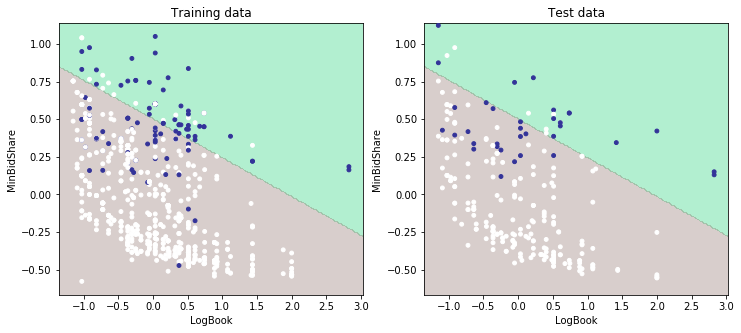

In [117]:
def visualizeClassifier(model, XTrain, yTrain, XTest, yTest, featureIdx, ax=None, cmap='terrain'):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize = (12,5))
    

    # Training data
    ax[0].scatter(XTrain.iloc[:, featureIdx[0]], XTrain.iloc[:, featureIdx[1]], 
                  c=yTrain, s=15, cmap=cmap, clim=(yTrain.min(), yTrain.max()), zorder=3)
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()
    ax[0].set(xlabel = XTrain.columns[featureIdx[0]])
    ax[0].set(ylabel = XTrain.columns[featureIdx[1]])
    
    # Fit the estimator to the training data
    model.fit(XTrain.iloc[:,featureIdx], yTrain)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(yTrain))
    contours = ax[0].contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)
    ax[0].set(xlim=xlim, ylim=ylim)
    ax[0].set(title = 'Training data')
    
    # Test data
    ax[1].scatter(XTest.iloc[:, featureIdx[0]], XTest.iloc[:, featureIdx[1]], 
                  c=yTest, s=15, cmap=cmap, clim=(yTest.min(), yTest.max()), zorder=3)
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()
    contours = ax[1].contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)
    ax[1].set(xlim=xlim, ylim=ylim)
    ax[1].set(title = 'Test data')
    ax[1].set(xlabel = XTrain.columns[featureIdx[0]])
    ax[1].set(ylabel = XTrain.columns[featureIdx[1]])
    
# Let's plot the classification surface for 'LogBook' and 'MinBidShare'
visualizeClassifier(classModel, XTrain, yTrain, XTest, yTest, featureIdx = np.array([6,7]))

So the classification boundary suggests that items with high book value and large reservation prices in relation to book values are more likely to remain unsold. Note that this is a very partial view since it does not show the effect of the other features.

Ok, before I hand over to you, let me drop a function here that fits, predicts and evaluates the performance of any classifier.

In [118]:
def ClassifierFitEval(classModel, XTrain, yTrain, XTest, yTest, plot = True):
    '''
    Fits, predicts and evaluates the classifier classModel.
    '''
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

    # Fit the classification model
    classModel.fit(X = XTrain, y = yTrain);

    # Compute predictions on test data
    yPredTest = classModel.predict(XTest) # Returns the most probable class
    yPredProbTest = classModel.predict_proba(XTest) # Returns the probabilities of the two classes

    # Evaluate the prediction: confusion matrix, precision, recall, ROC, AUC and all that
    confuseMat = confusion_matrix(yTest, yPredTest)
    ROC = roc_curve(yTest, yPredProbTest[:,1])
    AUC = roc_auc_score(yTest, yPredProbTest[:,1])
    if plot:
        sns.heatmap(confuseMat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('true label')
        plt.ylabel('predicted label');
        print(classification_report(yTest, yPredTest))

        plt.figure()
        plt.plot(ROC[0],ROC[1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate');
        plt.title('AUC = ' + str(round(AUC,3)));
    
    return(ROC, AUC)

And here is how you use the function on the logistic regression that we used above.

              precision    recall  f1-score   support

       False       0.71      0.50      0.59        34
        True       0.92      0.97      0.95       216

    accuracy                           0.90       250
   macro avg       0.82      0.73      0.77       250
weighted avg       0.90      0.90      0.90       250



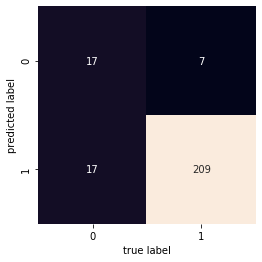

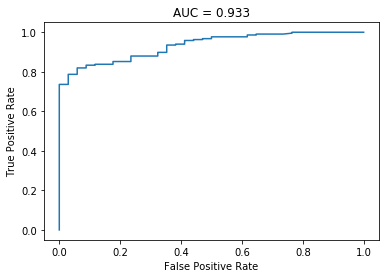

In [119]:
from sklearn import linear_model
classModel = linear_model.LogisticRegression(C = 10**10, solver ='lbfgs')
ROClr, AUClr = ClassifierFitEval(classModel, XTrain, yTrain, XTest, yTest, plot = True)

<font color="red">Ok, your turn now.</font> Fit, predict and evaluate a logistic regression with L1-penalty (Lasso) chosen with 5-fold cross-validation. Do CV over a grid of 100 values for the $\alpha$ Lasso hyperparameter. Comment on the results.

In [134]:
# YOUR CODE HERE

Fit, predict and evaluate a logistic regression with L2-penalty (Ridge) chosen with 5-fold cross-validation. Do CV over a grid of 100 values for the Ridge hyperparameter. Comment on the results.

In [133]:
# YOUR CODE HERE

Fit, predict and evaluate random forest classifier. Comment on the results.

In [132]:
# YOUR CODE HERE

Fit, predict and evaluate XGBoost classifier. Comment on the results.

In [131]:
# YOUR CODE HERE

Fit, predict and evaluate nearest neighbor classifier. Comment on the results.

In [130]:
# YOUR CODE HERE

# Plotting all ROC curves

Plot all the ROC curves from the above classifiers in a single figure. Comment.

In [128]:
# YOUR CODE HERE

# Printing all AUC

Print out all AUC from all classifiers. Comment.

In [129]:
# YOUR CODE HERE

Experiment with the settings of XGBoost. See which settings really matter and which seem to work best.

In [136]:
# YOUR CODE HERE